In [5]:
from keras.models import Sequential
from keras.layers import LSTM, Dense,Dropout, Bidirectional
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
#from keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.layers.merge import Concatenate
import matplotlib.gridspec as gridspec

import random
import scikitplot as skplot
#import matplotlib.pyplot as plt
import datetime
from datetime import date
from pandas_datareader import data as pdr

In [6]:
def generate_csv(symbol,filename):
    current_date=datetime.datetime.now()
    start_date=datetime.datetime(current_date.year-2,1,1)
    df = pdr.get_data_yahoo(symbol,start_date,current_date).reset_index()
    df.to_csv(filename)

In [7]:
#https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/
generate_csv('NFLX','nflx.csv')
url = "nflx.csv"
#url="dpz.csv"

df = pd.read_csv(url,parse_dates=['Date'],index_col='Date')

df.columns = [x.lower() for x in df.columns]
#print(df.head())
df=df.sort_values(by="Date")
#df=df.reset_index()

df=df.drop(["high","low","adj close"],axis=1)
print(df.columns)

df['open_pct_change']=df['open'].pct_change()

print(df["open_pct_change"])

df["open_pct_positive_count"]=0

#######caculate the occurrences of positive open
for index in range(len(df)):
    #print(df.iloc[index])
    count=0
    for index2 in (range(index,0,-1)):
        #print(df.iloc[index2]["open_pct_change"])
        if df.iloc[index2]["open_pct_change"]>0:
            count=count+1
            #print("found",count)
        else:
            break
    #print("count",count)
    df.iloc[index, df.columns.get_loc('open_pct_positive_count')]=count
    #print("new",df.iloc[index]["pct_pos_count"])
    
print(df[df["open_pct_positive_count"]>0])    



RemoteDataError: Unable to read URL: https://finance.yahoo.com/quote/NFLX/history?period1=1577872800&period2=1647943199&interval=1d&frequency=1d&filter=history
Response Text:
b'<!DOCTYPE html>\n  <html lang="en-us"><head>\n  <meta http-equiv="content-type" content="text/html; charset=UTF-8">\n      <meta charset="utf-8">\n      <title>Yahoo</title>\n      <meta name="viewport" content="width=device-width,initial-scale=1,minimal-ui">\n      <meta http-equiv="X-UA-Compatible" content="IE=edge,chrome=1">\n      <style>\n  html {\n      height: 100%;\n  }\n  body {\n      background: #fafafc url(https://s.yimg.com/nn/img/sad-panda-201402200631.png) 50% 50%;\n      background-size: cover;\n      height: 100%;\n      text-align: center;\n      font: 300 18px "helvetica neue", helvetica, verdana, tahoma, arial, sans-serif;\n  }\n  table {\n      height: 100%;\n      width: 100%;\n      table-layout: fixed;\n      border-collapse: collapse;\n      border-spacing: 0;\n      border: none;\n  }\n  h1 {\n      font-size: 42px;\n      font-weight: 400;\n      color: #400090;\n  }\n  p {\n      color: #1A1A1A;\n  }\n  #message-1 {\n      font-weight: bold;\n      margin: 0;\n  }\n  #message-2 {\n      display: inline-block;\n      *display: inline;\n      zoom: 1;\n      max-width: 17em;\n      _width: 17em;\n  }\n      </style>\n  <script>\n    document.write(\'<img src="//geo.yahoo.com/b?s=1197757129&t=\'+new Date().getTime()+\'&src=aws&err_url=\'+encodeURIComponent(document.URL)+\'&err=%<pssc>&test=\'+encodeURIComponent(\'%<{Bucket}cqh[:200]>\')+\'" width="0px" height="0px"/>\');var beacon = new Image();beacon.src="//bcn.fp.yahoo.com/p?s=1197757129&t="+new Date().getTime()+"&src=aws&err_url="+encodeURIComponent(document.URL)+"&err=%<pssc>&test="+encodeURIComponent(\'%<{Bucket}cqh[:200]>\');\n  </script>\n  </head>\n  <body>\n  <!-- status code : 404 -->\n  <!-- Not Found on Server -->\n  <table>\n  <tbody><tr>\n      <td>\n      <img src="https://s.yimg.com/rz/p/yahoo_frontpage_en-US_s_f_p_205x58_frontpage.png" alt="Yahoo Logo">\n      <h1 style="margin-top:20px;">Will be right back...</h1>\n      <p id="message-1">Thank you for your patience.</p>\n      <p id="message-2">Our engineers are working quickly to resolve the issue.</p>\n      </td>\n  </tr>\n  </tbody></table>\n  </body></html>'

In [ ]:
####### if the occurrences were greater than 2, did the pct change stay positive

#df["target"]=0
#for index in range(len(df)):
#    pct_chg=df.iloc[index]["open_pct_change"]
#    if index!=0:
#        prior_pct_chg_count=df.iloc[index-1]["open_pct_positive_count"]
#        if (prior_pct_chg_count>=2) & (pct_chg>0):
#             df.iloc[index, df.columns.get_loc('target')]=1

df["buy_count"]=0

for index in range(len(df)):
    count=0
    for index2 in (range(index,0,-1)):
        if df.iloc[index2]["open_pct_change"]>0:
            count=count+1
        else:
            break
    df.iloc[index, df.columns.get_loc('buy_count')]=count
    
df['action']=[ 'Sell' if x['buy_count']==0 else 'Buy' if x['buy_count']==2 else 'Hold' if x['buy_count'] > 2 else 'No Action' for key,x in df.iterrows()]
                
df["target"]=0
for index in range(len(df)):
    action=df.iloc[index]["action"]
    if (action=='Buy'):
             df.iloc[index, df.columns.get_loc('target')]=1
    elif (action=='Sell'):
             df.iloc[index, df.columns.get_loc('target')]=2
        
buy_list=df[df["target"]==1]
for index,item in buy_list.iterrows():
    print(index,item["open"],item["open_pct_positive_count"])
    



In [ ]:
def create_pig_table(basetable, target, variable):
  
    # Create groups for each variable
    groups = basetable[[target,variable]].groupby(variable)
    
    pig_table=groups[target].agg([np.mean, np.size]).reset_index()
    pig_table=pig_table.rename(columns={'mean':'Incidence','size':'Size'})
    #pig_table = groups[target].agg({'Incidence' : np.mean, 'Size' : np.size}).reset_index()

    # Return the predictor insight graph table
    return pig_table

# Calculate the predictor insight graph table for the variable gender
pig_table = create_pig_table(df, "target", "open_pct_positive_count")
print(pig_table)
print(len(df[df['open_pct_positive_count']==3]))

print("incidence show the average target value for each group")

pig_table.plot()
plt.show()

In [8]:
g=sns.catplot(x="target",data=df,kind="count")  #buy
plt.title('Buy(1) or Sell(2) or Hold(0)')
plt.show()

print('You want to find a stock where Hold counts are high')

NameError: name 'df' is not defined

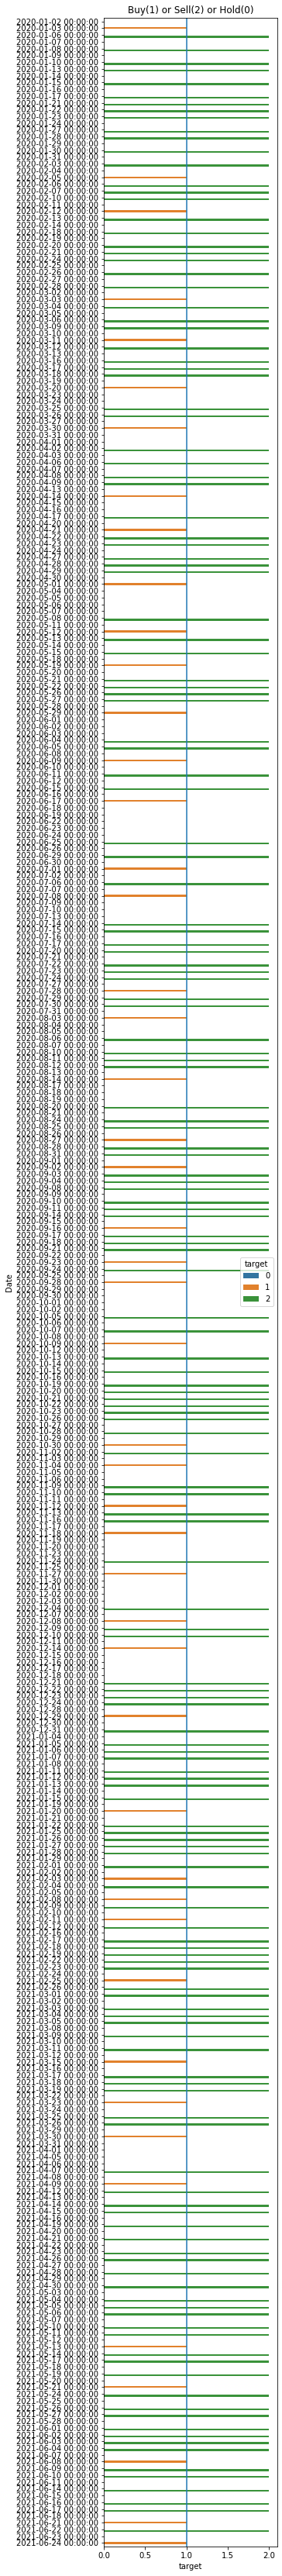

In [7]:

today = datetime.datetime.today()
filter=df.index.year >=  today.year-1
results=df[filter]

plt.figure(figsize=(4,60))
sns.barplot(data=results, x='target', y=results.index, hue='target')
plt.axvline(x=1, ymin=0, ymax=1)
plt.title('Buy(1) or Sell(2) or Hold(0)')
plt.show()

In [8]:
#https://towardsdatascience.com/demand-prediction-with-lstms-using-tensorflow-2-and-keras-in-python-1d1076fc89a0
def create_dataset(dataset, look_back=3):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [9]:
#X_train = np.reshape(train_set, (train_set.shape[0], 1, train_set.shape[1]))
#X_test = np.reshape(test_set, (test_set.shape[0], 1, test_set.shape[1]))

#samples=X_train.shape[0]

#features=len(data.columns)
#print("X_train {} y_train {} ".format(len(X_train),len(y_train)))
#print(len(X_test))
#COLUMNS=['open_pct_change','open']
COLUMNS=['open']
dataset=df[COLUMNS]
#dataset=np.array(dataset).reshape(-1,1)
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(np.array(dataset).reshape(-1,1))
#dataset=np.array(pd.DataFrame({"C1":[1,2,3,4,5,6],"C2":[-1,-2,-3,-4,-5,-6],"Y":[7,8,9,10,11,12]})).reshape(-1,1)

train_size = int(len(dataset) * 0.60)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]
#print(len(train), len(test))

look_back=3
trainX=[]
testX=[]
y_train=[]

#print(train)
#print(len(train))
#for i in range(len(train)-look_back-1):
#    a = train[i:(i+look_back)]
#    b = dataset[i + look_back]
#    print(a,b)
#    print("train sequence",a)
#    trainX.append(a)
#trainX=np.array(trainX)
#print(trainX)

#for i in range(len(test)-look_back-1):
#    a = test[i:(i+look_back)]
#    print("test sequence",a)
#    testX.append(a)
#testX=np.array(testX)
#print(testX)

trainX, y_train = create_dataset(train, look_back)
testX, y_test = create_dataset(test, look_back)

#print(y_train)

X_train = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
X_test = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

Instructions for updating:
Colocations handled automatically by placer.


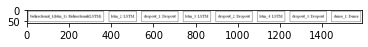

In [10]:
#1. The LSTM input layer must be 3D.
#2. The meaning of the 3 input dimensions are: samples, time steps, and features.
#3. The LSTM input layer is defined by the input_shape argument on the first hidden layer.
#4. The input_shape argument takes a tuple of two values that define the number of time steps and features.
#5. The number of samples is assumed to be 1 or more.

#Samples. One sequence is one sample. A batch is comprised of one or more samples.
#Time Steps. One time step is one point of observation in the sample.
#Features. One feature is one observation at a time step.

#input layer expects a 3D array of data when fitting the model and when making predictions, 
#even if specific dimensions of the array contain a single value, e.g. one sample or one feature.

#The input shape is supposed in the format (no_of_samples,no_of_timesteps,features)

#The input to every LSTM layer must be three-dimensional.
# expected input data shape: (batch_size, timesteps, data_dim)

n_future = 1
features=2
timeSteps=4

model = Sequential()

model.add(Bidirectional(LSTM(units=50, return_sequences=True, 
                             input_shape=(X_train.shape[1], 1))))

model.add(LSTM(units= 50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units= 50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units= 50))
model.add(Dropout(0.2))
model.add(Dense(units = n_future))

model.compile(optimizer="adam", loss="mean_squared_error", metrics=["acc"])



plot_model(model, to_file='model.png')
img=plt.imread('model.png')
plt.imshow(img)
plt.show()



In [11]:
model.fit(X_train, y_train,epochs=50  )

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
371/371 [==============================] - 1s 4ms/step - loss: 0.0889 - acc: 0.0027 
Epoch 2/50
371/371 [==============================] - 0s 175us/step - loss: 0.0594 - acc: 0.0027
Epoch 3/50
371/371 [==============================] - 0s 156us/step - loss: 0.0247 - acc: 0.0027
Epoch 4/50
371/371 [==============================] - 0s 175us/step - loss: 0.0158 - acc: 0.0027
Epoch 5/50
371/371 [==============================] - 0s 167us/step - loss: 0.0126 - acc: 0.0027
Epoch 6/50
371/371 [==============================] - 0s 175us/step - loss: 0.0102 - acc: 0.0027
Epoch 7/50
371/371 [==============================] - 0s 154us/step - loss: 0.0076 - acc: 0.0027
Epoch 8/50
371/371 [==============================] - 0s 180us/step - loss: 0.0053 - acc: 0.0027
Epoch 9/50
371/371 [==============================] - 0s 173us/step - loss: 0.0038 - acc: 0.0027
Epoch 10/50
371/371 [==============================] - 0s 175us/step - loss: 0.0

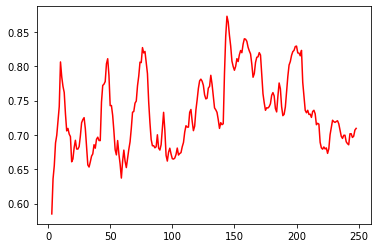

In [12]:
#print(X_test)
prediction = model.predict(X_test)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(prediction)+look_back, :] = prediction
# shift test predictions for plotting
#plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot, color='red')
#plt.plot(testPredictPlot)
#plt.legend(['Actual','Train','Test'])
plt.show()

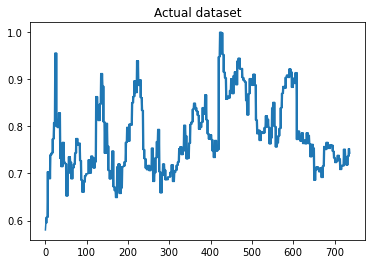

In [15]:
plt.plot(X_test.reshape(-1,1))
plt.title('Actual test dataset')
plt.show()